<a href="https://colab.research.google.com/github/annvorosh/GB/blob/StatMed/StatMed_L05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Курсив*
# Урок 5. Пермутационный тест, бутстрап анализ и метод максимального правдоподобия

### Сформулируйте несколько гипотез для 2 групп, которые можно проверить на имеющихся данных. Укажите, зависимые или независимые выборки, ЗП, НП.

Выберите подходящий тест и проверьте ваши предположения.
Задание выполняется на языке R и предоставляется в формате Google Colab.


In [ ]:
install.packages ('tidyverse')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages ('readxl')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library (tidyverse)
# require (readxl)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
install.packages("conflicted")
library(conflicted)
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Will prefer dplyr::lag over any other package.


In [ ]:
require (readxl)

In [ ]:
# Read high density lipids data
hdl <- read_tsv('/content/high_density_lipids.tsv') %>%
  select(-Name) %>%
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

# Read low density lipids data
ldl <- read_tsv('/content/low_density_lipids.tsv') %>%
  select(-Name) %>%
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

# Read metadata
meta <- read_xlsx('/content/metadata.xlsx', sheet = 1) %>%
  rename_with(make.names)

# Read descriptive metadata
descriptive <- read_xlsx('/content/metadata.xlsx', sheet = 2) %>%
  rename ('Variable' = '...1', 'Description' = '...2')
# Drop rows with missing values
descriptive <- drop_na(descriptive)


# Join high density lipids and low density lipids data
lipids <- full_join(hdl, ldl, by = c('Vial.number', 'Patient.number'), suffix = c('_hdl', '_ldl'))


Rows: 27 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPHDL1, GPHDL2, GPHDL3, GPHDL4, GPHDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPLDL1, GPLDL2, GPLDL3, GPLDL4, GPLDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
head(meta)


Vial.number,Patient.number,Sucrose,Name,Group,Date,Age,Plasma.volume,Ht,Wt,⋯,r.lat.max,r.ant.max,r.pos.max,l.lat.max,l.ant.max,l.pos.max,carotid.IMT.mean,Plaque,Statins,comorbidities
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,50,0,"Woodard, Dillon",0,2022-03-26,63,6.5,163,84.0,⋯,0.65,0.80,0.80,0.81,0.78,0.80,0.6425000,1,1,NA
2,51,0,"Kuck, Breanna",0,2023-12-23,47,5.5,179,111.0,⋯,1.03,0.92,1.03,1.03,1.03,1.09,0.8400000,1,0,NA
3,52,0,"Thomas, Terrance",1,2022-10-10,57,7.0,164,80.0,⋯,1.00,0.90,0.95,0.85,0.90,0.90,0.8500000,3,1,Type 2 diabetes mellitus; MI - 2016
4,53,0,"Moua, Kensue",1,2022-12-21,72,5.0,160,58.8,⋯,0.91,0.97,0.98,0.86,0.74,0.80,0.8241667,2,0,1-2 times per year hypertensive crises (Corinfar)
5,54,0,"Soriano, Ryan",1,2023-03-16,57,5.0,180,71.0,⋯,1.20,1.20,1.25,1.10,1.30,1.13,1.0983333,1,1,NA
6,55,0,"Munoz-Lujan, Evangelina",1,2023-03-25,79,6.2,160,64.0,⋯,0.88,0.80,0.90,1.07,1.00,1.30,0.8475000,2,0,"Cholecystitis, gastritis without exacerbation. Diffuse focal changes in the thyroid gland"


In [ ]:
# Вывод первых нескольких строк таблицы lipids
head(lipids)

Vial.number,Patient.number,GPHDL1,GPHDL2,GPHDL3,GPHDL4,GPHDL5,GPHDL6,GPHDL7,GPHDL8,⋯,G1_ldl,G2_ldl,G3_ldl,S0_ldl,S1_ldl,S2_ldl,S3_ldl,B_ldl,F_ldl,HM_ldl
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,0.38,1.78,0.14,0.05,0.73,2.90,1.57,2.57,⋯,4.09,68.91,3.57,3.98,28.18,42.46,1.95,0.02,1.67,13.02
3,52,0.43,1.30,0.23,0.05,0.59,2.62,1.62,3.86,⋯,5.16,68.22,3.11,4.64,30.43,39.86,1.56,0.02,1.69,14.16
4,53,0.41,3.86,0.31,0.10,0.96,3.19,2.42,3.75,⋯,3.95,68.03,4.50,3.78,29.37,41.13,2.20,0.02,1.89,13.89
5,54,0.50,1.79,0.23,0.06,0.77,2.96,1.76,3.00,⋯,4.63,66.91,4.03,4.44,28.54,40.64,1.95,0.02,2.03,14.25
6,55,0.40,3.69,0.17,0.03,0.80,3.04,1.62,3.23,⋯,4.05,64.01,5.27,3.72,26.71,40.39,2.51,0.02,2.70,16.06
7,56,0.37,2.96,0.22,0.05,1.00,3.00,2.11,3.06,⋯,4.10,65.99,4.70,4.03,28.44,39.99,2.33,0.02,1.61,13.82


In [ ]:
# Вывод первых нескольких строк таблицы descriptive
print(descriptive, n = Inf)


# A tibble: 25 × 2
   Variable Description                                      
   <chr>    <chr>                                            
 1 Ht       growth                                           
 2 Wt       the weight                                       
 3 BMI      body mass index                                  
 4 Sys      Systolic blood pressure                          
 5 Dia      Diastolic blood pressure                         
 6 PR       pulse                                            
 7 Sm       smoking                                          
 8 Dm       diabetes                                         
 9 HT       hypertension                                     
10 LVG      Left ventricular hypertrophy by electrocardiogram
11 AP       CAD                                              
12 MI       medical history of infarction                    
13 Str      medical history of stroke                        
14 A_C      family history of CAD                  

Деанонимизация данных: в отдельную таблицу patient_data отнесём данные о номере пробирки, ід пациента, его имени, дате
рождения и значение целевой группы по наличию атеросклеротического поражения каротидных артерий шеи. Из таблицы meta уберём соответсвующие столбцы.

In [ ]:
# Создание таблицы patient_data
patient_data <- meta %>%
  select(Vial.number, Patient.number, Name, Age, Group)

# Удаление соответствующих столбцов из таблицы meta
meta <- meta %>%
  select( -Name)

При помощи присвоения аттрибута "label" столбцам в таблице meta определили переменные и их описания в таблице descriptive, а затем присвоим атрибуты "label" столбцам таблицы meta в соответствии с этими описаниями.

In [ ]:
# Исправление опечатки в названии переменной
descriptive[10, "Variable"] <- 'LVG'

# Присвоение атрибутов "label" столбцам таблицы meta
attr(meta$Ht, "label") <- "growth"
attr(meta$Wt, "label") <- "the weight"
attr(meta$BMI, "label") <- "body mass index"
attr(meta$Sys, "label") <- "Systolic blood pressure"
attr(meta$Dia, "label") <- "Diastolic blood pressure"
attr(meta$PR, "label") <- "pulse"
attr(meta$Sm, "label") <- "smoking"
attr(meta$Dm, "label") <- "diabetes"
attr(meta$HT, "label") <- "hypertension"
attr(meta$LVH, "label") <- "Left ventricular hypertrophy by electrocardiogram"
attr(meta$MI, "label") <- "medical history of infarction"
attr(meta$Str, "label") <- "medical history of stroke"
attr(meta$A_C, "label") <- "family history of CAD"
attr(meta$A_H, "label") <- "family history hypertension"
attr(meta$A_D, "label") <- "family history diabetes"
attr(meta$Choi...25, "label") <- "cholesterol"
attr(meta$Choi...29, "label") <- "cholesterol"
attr(meta$Tgi...26, "label") <- "Triglycerides"
attr(meta$Tgi...30, "label") <- "Triglycerides"
attr(meta$HDLi...27, "label") <- "High density lipoprotein"
attr(meta$HDLi...31, "label") <- "High density lipoprotein"
attr(meta$LDLi...28, "label") <- "Low density lipoprotein"
attr(meta$LDLi...32, "label") <- "Low density lipoprotein"
attr(meta$AI, "label") <- "Atherogenicity index"


In [ ]:
head(meta)


Vial.number,Patient.number,Sucrose,Group,Date,Age,Plasma.volume,Ht,Wt,BMI,⋯,r.lat.max,r.ant.max,r.pos.max,l.lat.max,l.ant.max,l.pos.max,carotid.IMT.mean,Plaque,Statins,comorbidities
<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,50,0,0,2022-03-26,63,6.5,163,84.0,31.61579,⋯,0.65,0.80,0.80,0.81,0.78,0.80,0.6425000,1,1,NA
2,51,0,0,2023-12-23,47,5.5,179,111.0,34.64311,⋯,1.03,0.92,1.03,1.03,1.03,1.09,0.8400000,1,0,NA
3,52,0,1,2022-10-10,57,7.0,164,80.0,29.74420,⋯,1.00,0.90,0.95,0.85,0.90,0.90,0.8500000,3,1,Type 2 diabetes mellitus; MI - 2016
4,53,0,1,2022-12-21,72,5.0,160,58.8,22.96875,⋯,0.91,0.97,0.98,0.86,0.74,0.80,0.8241667,2,0,1-2 times per year hypertensive crises (Corinfar)
5,54,0,1,2023-03-16,57,5.0,180,71.0,21.91358,⋯,1.20,1.20,1.25,1.10,1.30,1.13,1.0983333,1,1,NA
6,55,0,1,2023-03-25,79,6.2,160,64.0,25.00000,⋯,0.88,0.80,0.90,1.07,1.00,1.30,0.8475000,2,0,"Cholecystitis, gastritis without exacerbation. Diffuse focal changes in the thyroid gland"


Цель исследования

по имеющимся данным лабораторных и инструментальных исследований (биохимический анализ крови, данные храматографии липидов, результаты ультразвукового исследования брахиоцефальных артерий шеи) определить влияние последних на риск развития атеросклеротического поражения артерий у пациента

Анализ датасета

• в таблице metadata.xlsx на первом листе отражены данные о пациенте, результатах биохимического анализа крови, показателей систолического и диастолического давления, величины пульса, антропометрических показателей пациента (рост, вес), ИМТ, ультразвукового исследования брахиоцефальных и коронарных артерий, факторы риска, такие как курение, диабет, наличие семейно-сцепленных заболеваний и др.

• в таблице metadata.xlsx на втором листе отражены данные об наименованиях столбцов первогол листа (колонка variable) и их расшифровка (колонка descriptive) а также интерпретация категорий отнесения пациентов относительно поражения артерий атеросклерозом.

• в таблицах high_density_lipids.tsv и low_density_lipids.tsv отражены данные об различных показателях хроматографии липопротеидв высокой и низкой плотности.

Конечные точки
1. степень стоноза бляшкой каротидных сосудов
2. plaque score
3. факт наличия ИБС

Тип проводимого исследования

• обсервационное аналитическое исследование. Случай-контроль


Типы шкал

• Количественные непрерывные шкалы:
Интервальная шкала (нет представительства в датасете)

• Шкала отношений (возраст, вес, рост, показатели систолического и диастолического давления)

• Качественные дискретные шкалы:

1. Номинальная шкала(диагнозы, указанные в столбце comorbidities)

2. Порядковая шкала(показатель Plaque - степень выраженности АТС-бляшки)

Составить несколько
эмпирических гипотез, которые можно осмысленно проверить на этих данных

• Приводит ли фактор курения к поражению атеросклерозом артерий

• Приводит ли повышение уровня триглициридов крови к поражению атеросклерозом артерий.

• Приводит ли повышение уровня холестерина крови к поражению атеросклерозом артерий

• Приводит ли повышение уровня липопротеидов высокой плотности крови к снижению риска развития атеросклероза артерий.

# описательные статистики

In [ ]:
summary(meta)

  Vial.number    Patient.number     Sucrose           Group       
 Min.   : 1.00   Min.   :25.00   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:10.25   1st Qu.:36.25   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :19.50   Median :41.50   Median :1.0000   Median :1.0000  
 Mean   :19.50   Mean   :43.76   Mean   :0.6316   Mean   :0.6316  
 3rd Qu.:28.75   3rd Qu.:53.75   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :38.00   Max.   :63.00   Max.   :1.0000   Max.   :1.0000  
                                                                  
      Date                             Age        Plasma.volume   
 Min.   :2022-01-01 00:00:00.00   Min.   :47.00   Min.   : 5.000  
 1st Qu.:2022-05-16 12:00:00.00   1st Qu.:60.25   1st Qu.: 6.500  
 Median :2022-08-14 00:00:00.00   Median :65.00   Median :10.250  
 Mean   :2022-10-18 10:06:18.95   Mean   :65.58   Mean   : 9.453  
 3rd Qu.:2023-03-14 00:00:00.00   3rd Qu.:70.00   3rd Qu.:11.875  
 Max.   :2023-12-23 00:00:00.00   Max.   :83.00   Max.   :13.0

In [ ]:
summary(meta$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.00   60.25   65.00   65.58   70.00   83.00 

In [ ]:
# Создание нового столбца "Age_Group" на основе возрастных групп
meta$Age_Group <- cut(meta$Age, breaks = c(40, 50, 60, 70, Inf), labels = c("40-50", "51-60", "61-70", "71+"))


In [ ]:
# Для перевода числовых переменных в факторы применим функцию factor()
meta$Sucrose <- factor(meta$Sucrose)
meta$Group <- factor(meta$Group)
meta$HT <- factor(meta$HT)
meta$LVH <- factor(meta$LVH)
meta$IHD <- factor(meta$IHD)
meta$MI <- factor(meta$MI)
meta$Str <- factor(meta$Str)
meta$A_C <- factor(meta$A_C)
meta$A_H <- factor(meta$A_H)
meta$A_D <- factor(meta$A_D)
meta$Plaque <- factor(meta$Plaque)
meta$Statins <- factor(meta$Statins)
meta$comorbidities <- factor(meta$comorbidities)
meta$Age_Group <- factor(meta$Age_Group)


Будем использовать skimr для вычисления сводных статистик для факторных и числовых переменных в вашем наборе данных.

In [ ]:
install.packages("skimr")

library(skimr)

# Вычисление сводных статистик для факторных переменных
factor_desc_stats <- skimr::skim(select(meta, where(is.factor))) %>%
  select(skim_variable, factor.top_counts)

factor_desc_stats

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# A tibble: 14 × 2
   skim_variable factor.top_counts              
   <chr>         <chr>                          
 1 Sucrose       1: 24, 0: 14                   
 2 Group         1: 24, 0: 14                   
 3 HT            1: 23, 0: 15                   
 4 LVH           0: 24, 1: 14                   
 5 IHD           0: 19, 1: 19                   
 6 MI            0: 34, 1: 4                    
 7 Str           0: 36, 1: 2                    
 8 A_C           0: 23, 1: 15                   
 9 A_H           0: 22, 1: 16                   
10 A_D           0: 31, 1: 7                    
11 Plaque        2: 17, 1: 15, 0: 3, 3: 3       
12 Statins       0: 24, 1: 13                   
13 comorbidities 1-2: 1, 2/2: 1, App: 1, CAD: 1 
14 Age_Group     61-: 19, 71+: 9, 51-: 8, 40-: 2


ERROR: Error in is.null(text_repr) || nchar(text_repr) == 0L: 'length = 2' in coercion to 'logical(1)'


In [ ]:
# Вычисление сводных статистик для числовых переменных
num_desc_stats <- skimr::skim(select(meta, where(is.numeric)))
num_desc_stats

── Data Summary ────────────────────────
                           Values                      
Name                       select(meta, where(is.num...
Number of rows             38                          
Number of columns          34                          
_______________________                                
Column type frequency:                                 
  numeric                  34                          
________________________                               
Group variables            None                        

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable    n_missing complete_rate     mean     sd      p0     p25
 1 Vial.number              0             1  19.5    11.1     1      10.2  
 2 Patient.number           0             1  43.8    11.1    25      36.2  
 3 Age                      0             1  65.6     8.67   47      60.2  
 4 Plasma.volume            0             1   9.45    2.88    5      

ERROR: Error in is.null(text_repr) || nchar(text_repr) == 0L: 'length = 12' in coercion to 'logical(1)'


Исходя из предоставленных описательных статистик, можно сделать следующие выводы:

1. Возраст (Age): Средний возраст участников составляет около 65.6 лет, с минимальным значением 47 и максимальным 83. Распределение возраста кажется нормальным, без явных выбросов.
2. Вес (Wt): Средний вес составляет около 74.9 кг, с минимальным значением 56.5 кг и максимальным 111 кг. Распределение веса также кажется нормальным.
3. Индекс массы тела (BMI): Средний BMI составляет около 27.5, что указывает на наличие избыточного веса у участников исследования. Распределение BMI также кажется нормальным.
4. Давление (Sys, Dia): Среднее систолическое давление (Sys) составляет около 132 мм ртутного столба, а среднее диастолическое давление (Dia) - около 80.1 мм ртутного столба. Оба параметра имеют нормальное распределение.


Теперь мы можем построить гистограммы для этих и некоторых других переменных, чтобы точнее визуально оценить их распределение.

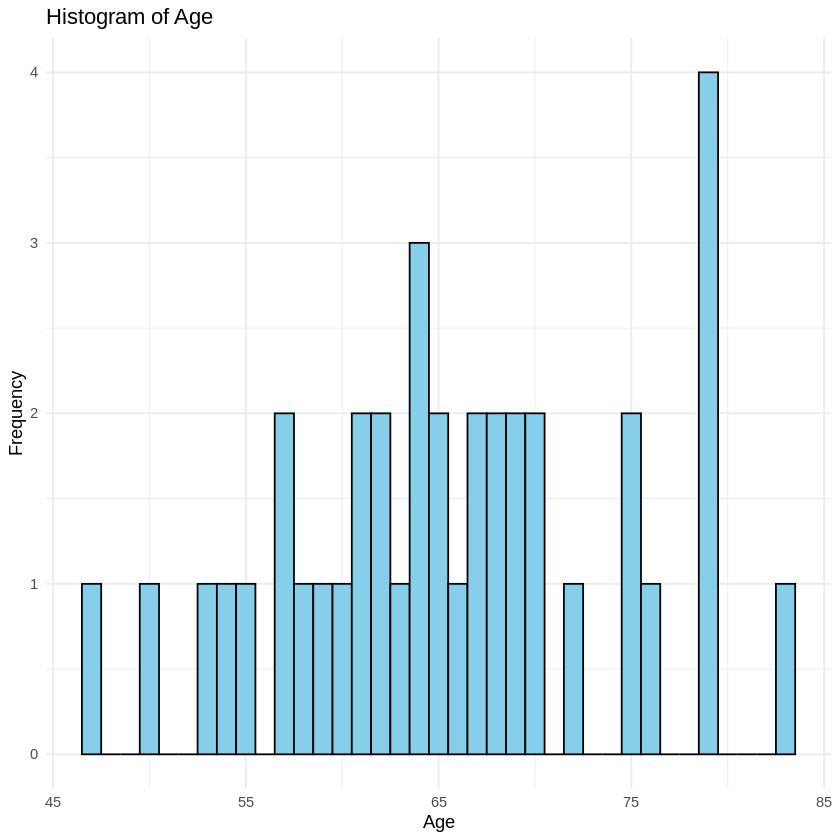

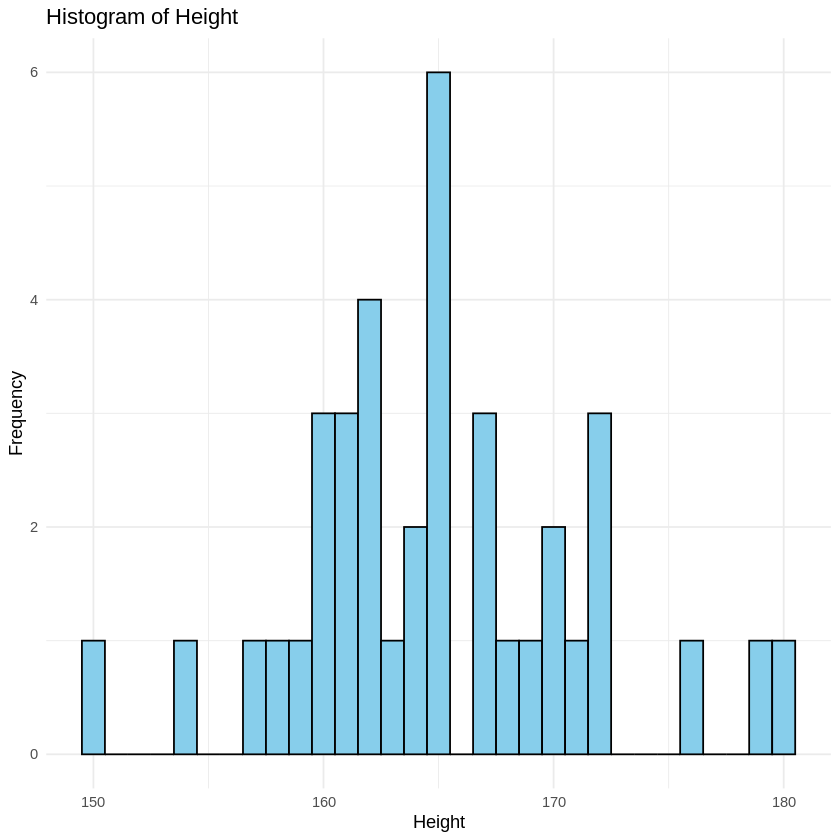

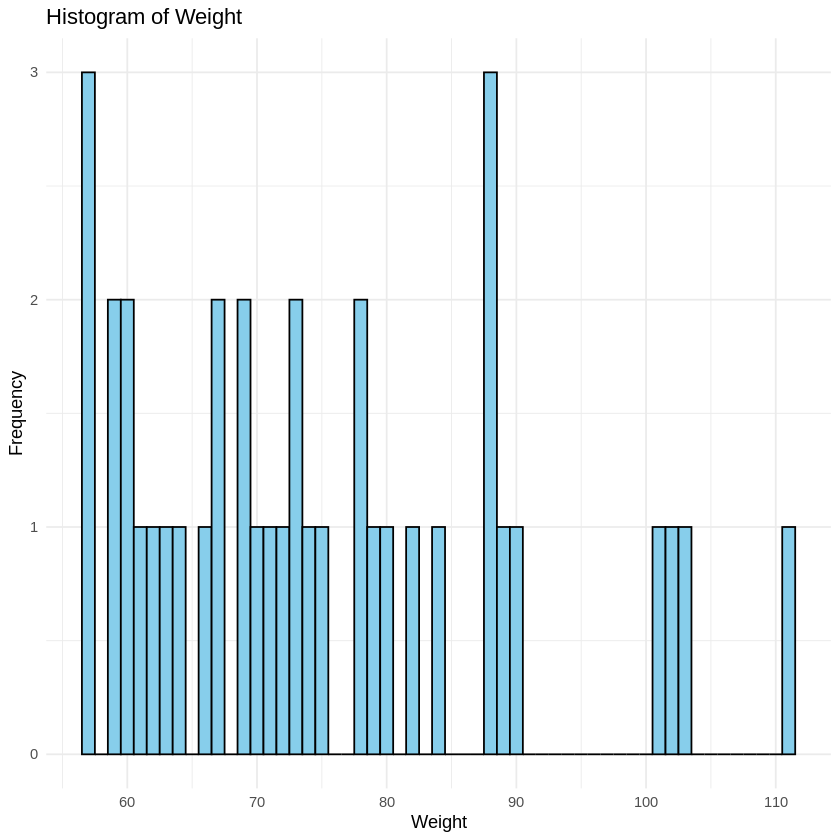

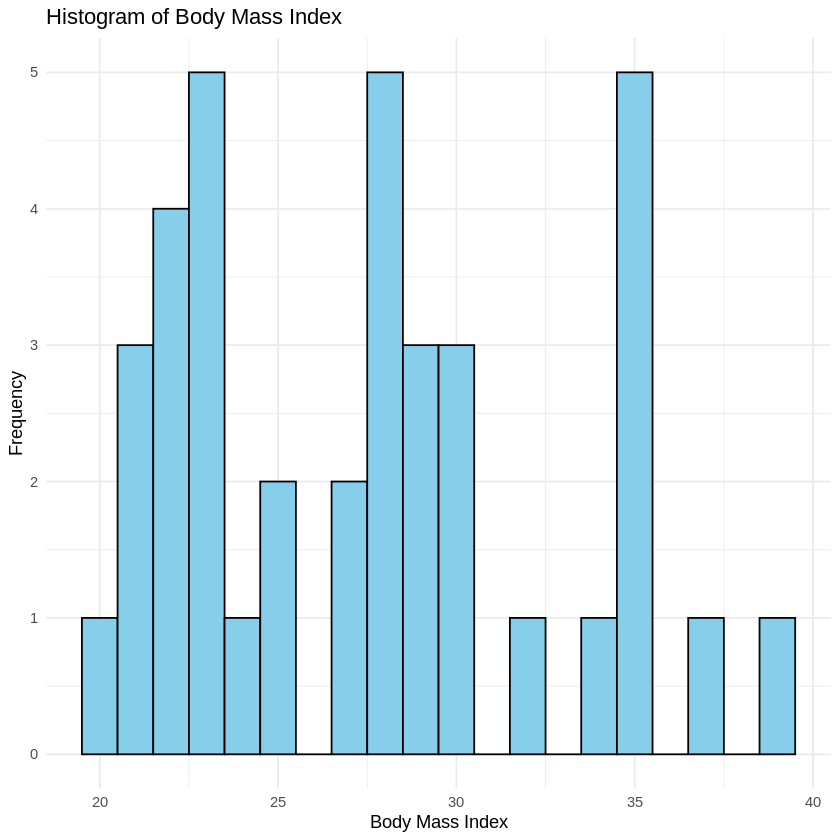

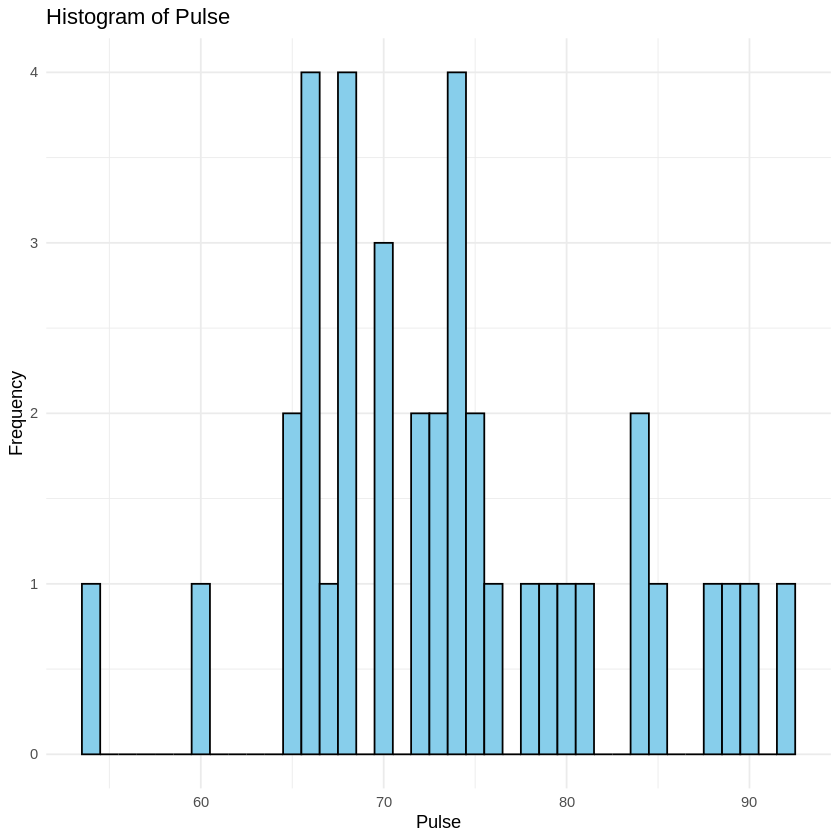

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


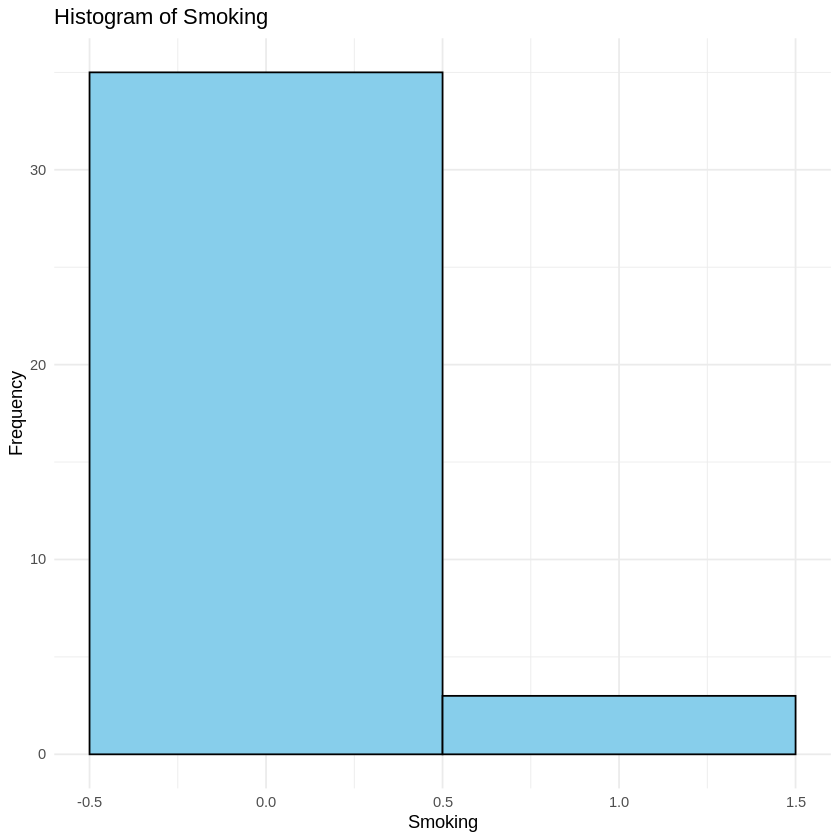

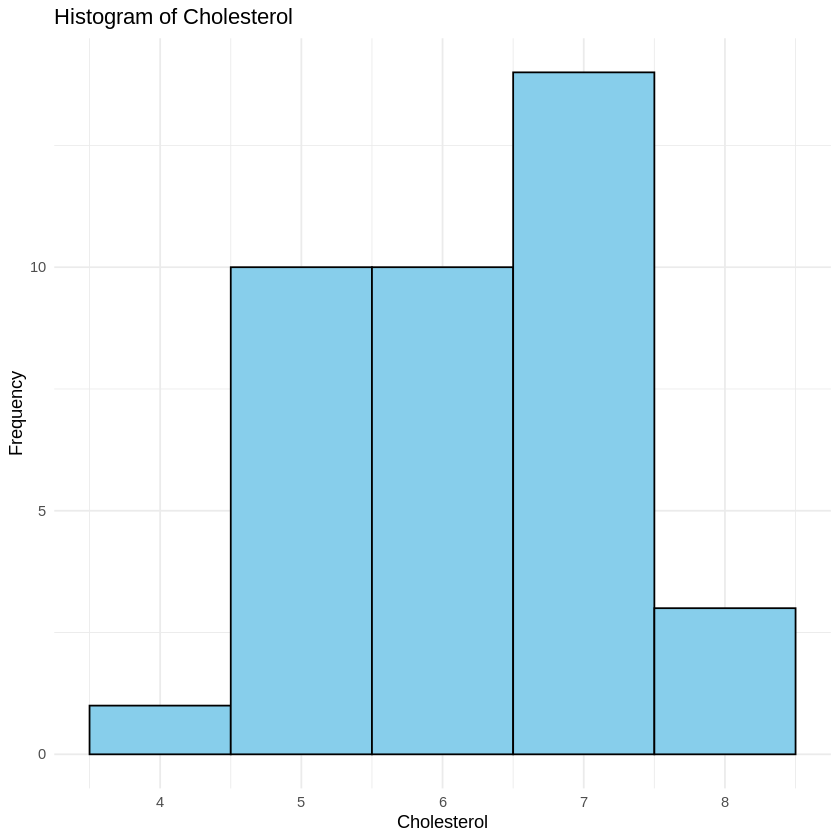

In [ ]:
library(ggplot2)

# Функция для построения гистограммы с использованием ggplot2
histogram_plot_ggplot <- function(data, variable, label) {
  ggplot(data, aes(x = !!sym(variable))) +
    geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
    labs(title = paste("Histogram of", label),
         x = label, y = "Frequency") +
    theme_minimal()
}

# Список выбранных переменных и их названий
selected_variables <- c("Age", "Ht", "Wt", "BMI", "PR", "Sm", "Choi...29")
selected_labels <- c("Age", "Height", "Weight", "Body Mass Index", "Pulse", "Smoking", "Cholesterol")

# Построение гистограмм с использованием ggplot2 для выбранных переменных
hist_plots_ggplot <- mapply(histogram_plot_ggplot,
                             data = list(meta),
                             variable = selected_variables,
                             label = selected_labels,
                             SIMPLIFY = FALSE)

# Показать гистограммы
hist_plots_ggplot


Smoking:  Имеет распределение Бернули.

In [ ]:
# Проверка нормальности распределения переменной Age
shapiro.test(meta$Age)
shapiro.test(meta$Ht)
shapiro.test(meta$Wt)
shapiro.test(meta$BMI)
shapiro.test(meta$PR)
shapiro.test(meta$Choi...25)


	Shapiro-Wilk normality test

data:  meta$Age
W = 0.9835, p-value = 0.8362



	Shapiro-Wilk normality test

data:  meta$Ht
W = 0.9761, p-value = 0.5801



	Shapiro-Wilk normality test

data:  meta$Wt
W = 0.93095, p-value = 0.02149



	Shapiro-Wilk normality test

data:  meta$BMI
W = 0.93281, p-value = 0.02462



	Shapiro-Wilk normality test

data:  meta$PR
W = 0.96442, p-value = 0.2634



	Shapiro-Wilk normality test

data:  meta$Choi...25
W = 0.96942, p-value = 0.3763


Результаты теста Шапиро-Уилка для каждой из переменных:

Age: p-значение = 0.8362. Имеет нормальное распределение.

Ht: p-значение = 0.5801. Имеет нормальное распределение.

Wt: p-значение = 0.02149. Имеет ненормальное распределение, визуально похоже на бимодальное.

BMI: p-значение = 0.02462. Нулевая гипотеза о нормальности распределения отвергается на уровне значимости 0.05. Имеет ненормальное распределение.

PR: p-значение = 0.2634. Имеет нормальное распределение.

Choi...25: p-значение = 0.3763. Имеет нормальное распределение.

При интерпретации результатов следует обратить внимание на значение p-значения и уровень значимости. Если p-значение меньше выбранного уровня значимости (обычно 0.05), тогда нулевая гипотеза отвергается, и данные не считаются нормально распределенными.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


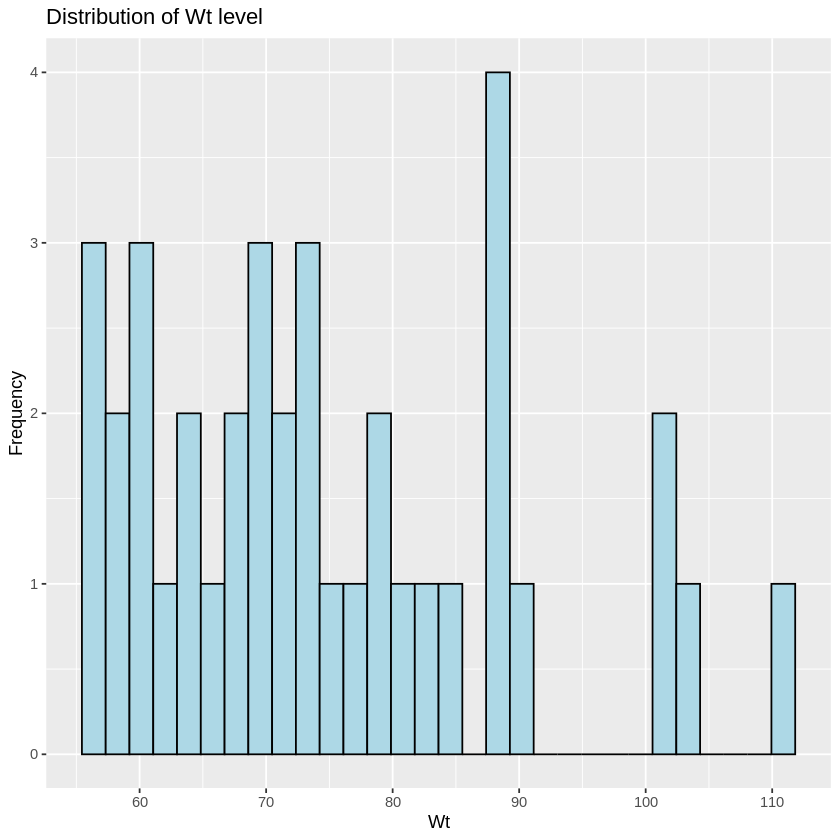

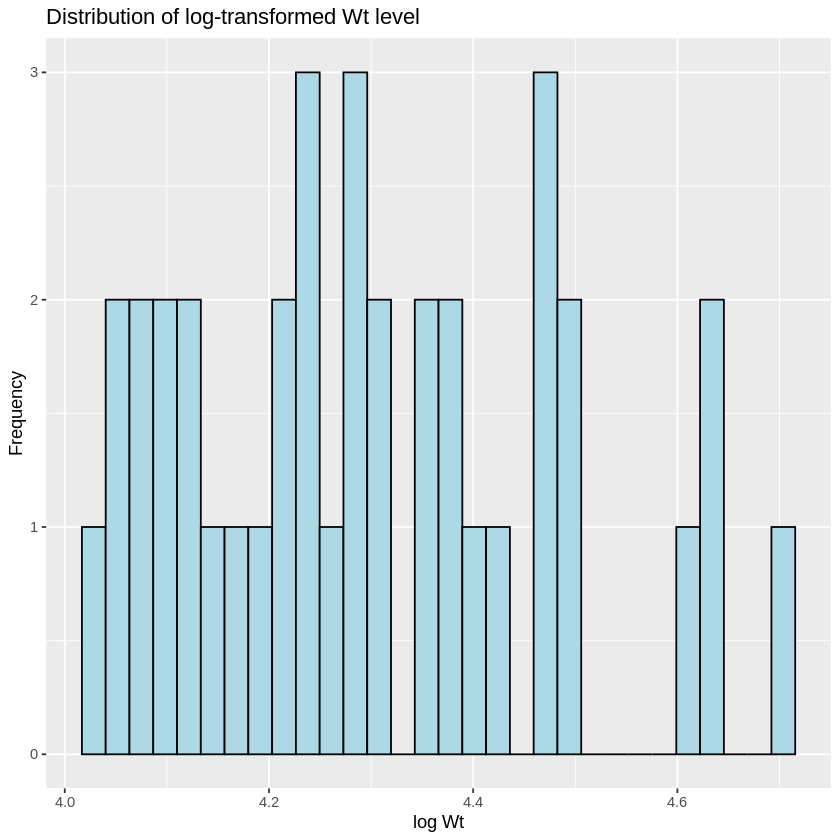

In [ ]:

# Построение гистограммы для переменной Wt
ggplot(as.data.frame(meta), aes(x = Wt)) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of Wt level") +
  scale_x_continuous(name = "Wt") +
  scale_y_continuous(name = "Frequency")

# Построение гистограммы для логарифмически преобразованной переменной Wt_log
ggplot(as.data.frame(meta), aes(x = log(Wt))) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of log-transformed Wt level") +
  scale_x_continuous(name = "log Wt") +
  scale_y_continuous(name = "Frequency")


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


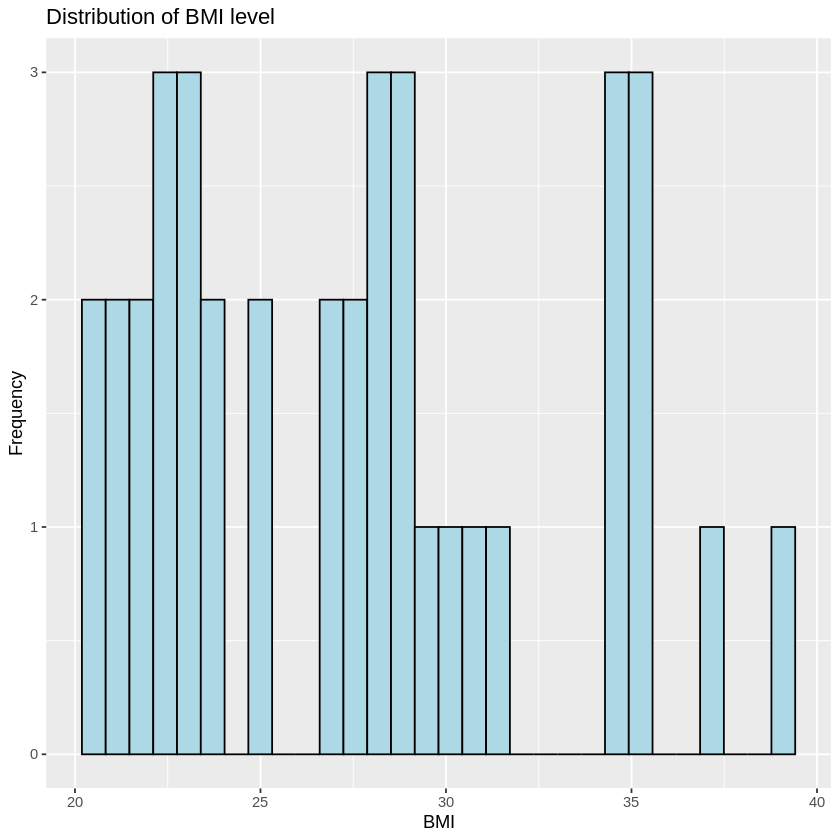

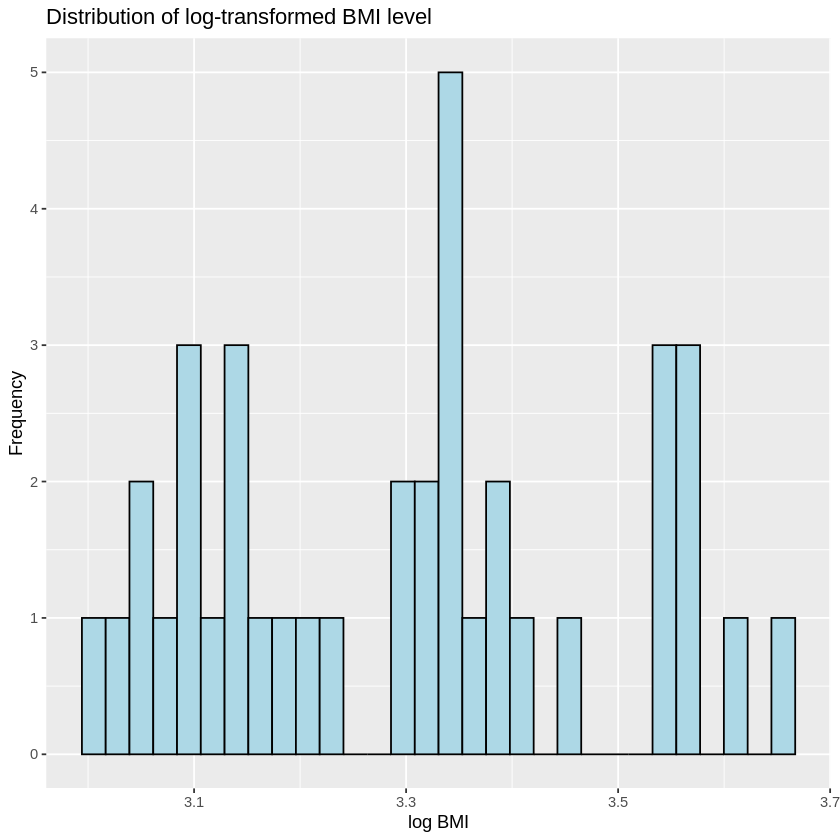

In [ ]:
# Построение гистограммы для переменной BMI
ggplot(as.data.frame(meta), aes(x = BMI)) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of BMI level") +
  scale_x_continuous(name = "BMI") +
  scale_y_continuous(name = "Frequency")

# Построение гистограммы для логарифмически преобразованной переменной BMI_log
ggplot(as.data.frame(meta), aes(x = log(BMI))) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of log-transformed BMI level") +
  scale_x_continuous(name = "log BMI") +
  scale_y_continuous(name = "Frequency")

### Cформулируем несколько гипотез на основе данных:

### Гипотеза 1: Средний возраст пациентов с диабетом отличается от среднего возраста пациентов без диабета.
- Группы: пациенты с диабетом и пациенты без диабета.
- Зависимость: независимые выборки.
- Переменная: возраст (Age).
- Тест: двухвыборочный t-тест.

### Гипотеза 2: Средний индекс массы тела (BMI) у курящих и некурящих пациентов различается.
- Группы: курящие и некурящие пациенты.
- Зависимость: независимые выборки.
- Переменная: индекс массы тела (BMI).
- Тест: двухвыборочный t-тест.

### Гипотеза 3: Присутствует ли связь между уровнем холестерина (Choi...25) и наличием инфаркта миокарда (MI) у пациентов.
- Группы: пациенты с инфарктом миокарда и без инфаркта миокарда.
- Зависимость: независимые выборки.
- Переменные: уровень холестерина и наличие инфаркта миокарда.
- Тест: двухвыборочный t-тест.

In [ ]:
# Гипотеза 1: средний возраст пациентов с диабетом отличается от среднего возраста пациентов без диабета
t.test(meta$Age ~ meta$Dm)

# Гипотеза 2: средний индекс массы тела (BMI) у курящих и некурящих пациентов различается
t.test(meta$BMI ~ meta$Sm)

# Гипотеза 3: связь между уровнем холестерина и наличием инфаркта миокарда
t.test(meta$Choi...25 ~ meta$MI)



	Welch Two Sample t-test

data:  meta$Age by meta$Dm
t = 1.0045, df = 3.9032, p-value = 0.3733
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -7.66496 16.22378
sample estimates:
mean in group 0 mean in group 1 
       66.02941        61.75000 



	Welch Two Sample t-test

data:  meta$BMI by meta$Sm
t = 1.5451, df = 2.694, p-value = 0.23
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -4.422713 11.802707
sample estimates:
mean in group 0 mean in group 1 
       27.83793        24.14793 



	Welch Two Sample t-test

data:  meta$Choi...25 by meta$MI
t = -0.3302, df = 3.3571, p-value = 0.7608
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -97.42093  78.09740
sample estimates:
mean in group 0 mean in group 1 
       239.5882        249.2500 


#Выводы:

##Возраст (Age) и наличие диабета (Dm):
Нет статистически значимой разницы в среднем возрасте между группами пациентов с диабетом (группа 1) и без него (группа 0) (t(3.9032) = 1.0045, p = 0.3733, 95% ДИ [-7.66496, 16.22378]). Следовательно, наличие диабета не оказывает значимого влияния на средний возраст пациентов.
##Индекс массы тела (BMI) и курение (Sm):
Средний BMI в группе курильщиков (группа 1) ниже, чем у некурящих (группа 0), однако разница не является статистически значимой (t(2.694) = 1.5451, p = 0.23, 95% ДИ [-4.422713, 11.802707]). Это означает, что наличие курения не связано с значимым изменением среднего значения BMI.
##Уровень холестерина (Choi...25) и наличие инфаркта миокарда (MI):
Нет статистически значимой разницы в среднем уровне холестерина между группами пациентов с и без инфаркта миокарда (t(3.3571) = -0.3302, p = 0.7608, 95% ДИ [-97.42093, 78.09740]). Это означает, что наличие инфаркта миокарда не связано с изменением среднего уровня холестерина.

In [ ]:
unique(meta$Group)
unique(meta$Plaque)


[1] 0 1
Levels: 0 1

[1] 1 3 2 0
Levels: 0 1 2 3

     Plaque
Group  0  1  2  3
    0  3 11  0  0
    1  0  4 17  3

Warning message in chisq.test(ctable_meta):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  ctable_meta
X-squared = 25.394, df = 3, p-value = 1.277e-05



	Fisher's Exact Test for Count Data

data:  ctable_meta
p-value = 7.017e-07
alternative hypothesis: two.sided


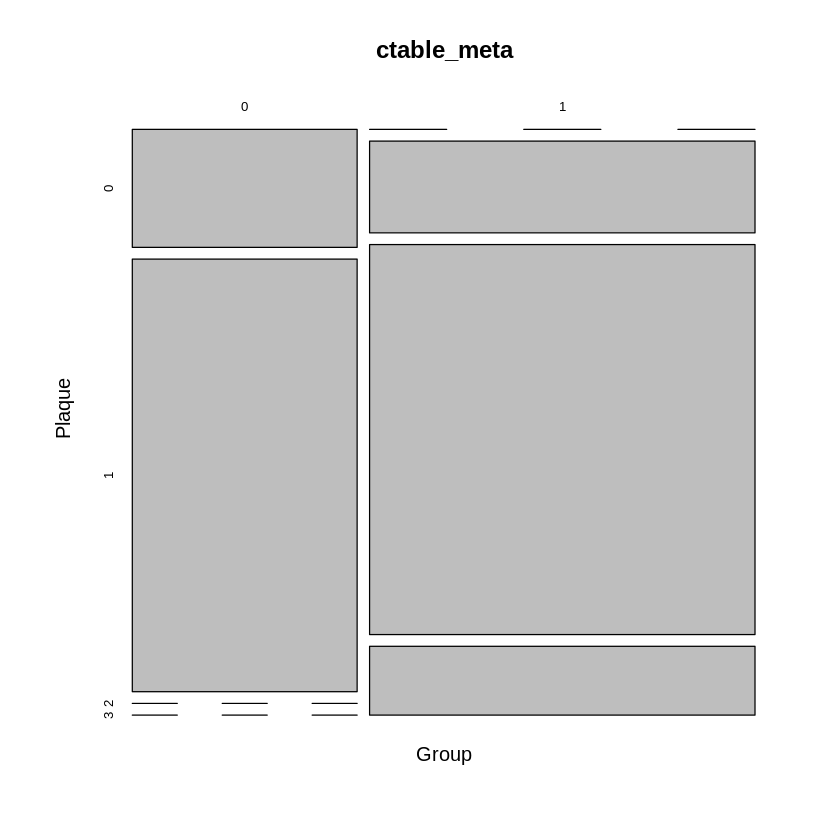

In [ ]:
# Создание трехмерной таблицы
ctable_meta <- meta %>%
  filter(!is.na(Group) & !is.na(Plaque)) %>%
  xtabs(~ Group + Plaque, data = .)

# Вывод трехмерной таблицы
ctable_meta

# Визуализация трехмерной таблицы
mosaicplot(ctable_meta)

# Тест хи-квадрат
chisq.test(ctable_meta)

# Тест Фишера
fisher.test(ctable_meta)


Результаты тестов на независимость переменных "Group" и "Plaque" показывают, что существует статистически значимая связь между этими переменными.

Примечание: В медико-биологических исследованиях в качестве критического порога значимости традиционно выбирается уровень 0,05, что допускает наличие ошибки первого рода 5 раз в 100 сравнениях. При р≤ α различия принимаются статистически значимыми.

- Тест хи-квадрат дал значимое значение p < 0.05 (p = 1.277e-05), что указывает на то, что мы отвергаем нулевую гипотезу о независимости переменных.
- Тест Фишера также дал значимое значение p < 0.05 (p = 7.017e-07), подтверждая статистическую значимость связи между переменными.

Эти результаты говорят о том, что наличие или отсутствие атеросклеротического налета (Plaque) может зависеть от группы риска (Group).

In [ ]:
install.packages("GGally")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘Rcpp’, ‘ggstats’, ‘plyr’




In [ ]:
library(GGally)
library(dplyr)

pdf("pair_plot_meta.pdf", height = 12, width = 12)

# Отфильтруем строки с NA значениями в нужных столбцах
filtered_data <- meta %>%
  drop_na(Age, BMI, Choi...25, Sm, Sys, Dia, MI, Str)

# Выберем нужные столбцы
selected_data <- filtered_data %>%
  dplyr::select(Age, BMI, Choi...25, Sm, Sys, Dia, MI, Str)

# Создадим матрицу точечных диаграмм и сохраняем в PDF
ggpairs(selected_data,
        upper = list(continuous = wrap("cor", size = 3)),
        lower = list(continuous = wrap("smooth", alpha = 0.3, size = 0.1)))

dev.off()  # Закрываем PDF файл


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


png 
  2

In [ ]:
# Проверка типа данных и длины переменной meta$Sys
class(meta$Sys)
length(meta$Sys)
table(lengths(meta$Sys))

[1] "numeric"

[1] 38


 1 
38 

In [ ]:
class(meta$Sys)

[1] "numeric"

In [ ]:
meta$Sys <- unlist(meta$Sys)

In [ ]:
class(meta$Sys)

[1] "numeric"

In [ ]:
is.numeric(meta$Sys) # Проверить, являются ли данные числовыми
length(meta$Sys)     # Проверить длину вектора данных

[1] TRUE

[1] 38

In [ ]:
install.packages("fitdistrplus")


# Загрузка пакета fitdistrplus
library(fitdistrplus)

# Создание списка возможных распределений
possible_distributions <- c("norm", "lnorm", "exp", "gamma", "weibull", "logis", "pois")

# Итеративный анализ каждого распределения
fits <- lapply(possible_distributions, function(dist) fitdist(meta$Sys, dist))

# Сводная таблица результатов
results_summary <- lapply(fits, summary)
results_summary

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



ERROR: Error in fitdist(meta$Sys, dist): data must be a numeric vector of length greater than 1


Из представленных результатов можно заключить, что нормальное, логнормальное, гамма- и вейбулловское распределения лучше всего соответствуют данным, в то время как экспоненциальное распределение, распределение Пуассона и логистическое распределение демонстрируют более слабое соответствие.

Для анализа влияния двух зависимых переменных (Sys и Dia) и двух факторов (Group и HT) нам нужно использовать многомерный анализ дисперсии (MANOVA). Для этого мы будем использовать функцию manova().

In [ ]:
# Проведение MANOVA анализа
manova_result <- manova(cbind(Sys, Dia) ~ Group * HT, data = meta)

# Вывод результатов MANOVA анализа
summary(manova_result)



          Df   Pillai approx F num Df den Df Pr(>F)
Group      1 0.084007  1.51323      2     33 0.2351
HT         1 0.068270  1.20899      2     33 0.3114
Group:HT   1 0.051777  0.90097      2     33 0.4159
Residuals 34                                       

На основании результатов MANOVA анализа нет достаточных доказательств для того, чтобы отвергнуть нулевые гипотезы о том, что факторы Group, HT и их взаимодействие не оказывают статистически значимого влияния на зависимые переменные Sys и Dia.

## Итак, мы проверили несколько гипотез:

1. **Гипотеза о влиянии группы на переменные Sys и Dia:**
   - **Гипотеза:** Существует статистически значимое различие между группами в отношении переменных Sys и Dia.
   - **Результат:** Результаты ANOVA и MANOVA показывают, что влияние группы на переменные Sys и Dia не является статистически значимым (p > 0.05). Это означает, что нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что средние значения Sys и Dia не различаются между группами.

2. **Гипотеза о влиянии времени гипертензии на переменные Sys и Dia:**
   - **Гипотеза:** Существует статистически значимое различие в переменных Sys и Dia в зависимости от времени гипертензии.
   - **Результат:** Результаты ANOVA и MANOVA также не показывают статистически значимого влияния времени гипертензии на переменные Sys и Dia (p > 0.05). Таким образом, нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что средние значения Sys и Dia не различаются в зависимости от времени гипертензии.

3. **Гипотеза о взаимодействии группы и времени гипертензии на переменные Sys и Dia:**
   - **Гипотеза:** Существует статистически значимое взаимодействие между группой и временем гипертензии в отношении переменных Sys и Dia.
   - **Результат:** Результаты ANOVA и MANOVA не подтверждают статистически значимого взаимодействия между группой и временем гипертензии в отношении переменных Sys и Dia (p > 0.05). Таким образом, нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что влияние группы и времени гипертензии на переменные Sys и Dia не зависит друг от друга.

Таким образом, на основании результатов ANOVA и MANOVA, мы не можем отвергнуть нулевые гипотезы о том, что средние значения переменных Sys и Dia не различаются между группами, в разные периоды времени гипертензии, а также в их взаимодействии.

## Проверим еще несколько гипотез

4. **Гипотеза 4: Средний возраст пациентов с диабетом отличается от среднего возраста пациентов без диабета.**

In [ ]:
# Проведение t-теста для сравнения среднего возраста в двух группах
t_test_age <- t.test(Age ~ Group, data = meta)

# Вывод результатов t-теста
t_test_age



	Welch Two Sample t-test

data:  Age by Group
t = -1.7093, df = 25.064, p-value = 0.09975
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -10.997469   1.021278
sample estimates:
mean in group 0 mean in group 1 
       62.42857        67.41667 


значение p-value (0.09975) близко к уровню значимости 0.05, что может указывать на тенденцию к различиям в среднем возрасте между двумя группами.

5. **Гипотеза 5: Средний индекс массы тела (BMI) у курящих и некурящих пациентов различается.**

In [ ]:
# Преобразование переменной "Sm" в фактор
meta$Sm <- as.factor(meta$Sm)

# Проверка типа данных переменной "Sm"
class(meta$Sm)


[1] "factor"

In [ ]:
# Выполнение t-теста для сравнения среднего BMI у курящих и некурящих пациентов
t_test_result <- t.test(BMI ~ Sm, data = meta)

# Вывод результатов
t_test_result



	Welch Two Sample t-test

data:  BMI by Sm
t = 1.5451, df = 2.694, p-value = 0.23
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -4.422713 11.802707
sample estimates:
mean in group 0 mean in group 1 
       27.83793        24.14793 


Значение p больше уровня значимости 0.05, что означает, что нет статистически значимых различий в среднем индексе массы тела между курящими и некурящими пациентами на уровне значимости 0.05.


6. **Гипотеза 6: Присутствует ли связь между уровнем холестерина и наличием инфаркта миокарда у пациентов..**

In [ ]:
# Преобразование переменной "Sm" в фактор
meta$MI <- as.factor(meta$MI)

# Проверка типа данных переменной "Sm"
class(meta$MI)


# Выполнение t-теста для сравнения среднего BMI у курящих и некурящих пациентов
t_test_result <- t.test(Choi...25 ~ MI, data = meta)

# Вывод результатов
t_test_result

[1] "factor"


	Welch Two Sample t-test

data:  Choi...25 by MI
t = -0.3302, df = 3.3571, p-value = 0.7608
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -97.42093  78.09740
sample estimates:
mean in group 0 mean in group 1 
       239.5882        249.2500 


Значение p больше уровня значимости 0.05, что означает, что нет статистически значимых различий в уровне холестерина между пациентами с инфарктом миокарда и пациентами без инфаркта миокарда на уровне значимости 0.05.


# ПРАВКА ДЗ_4
выше исправила тестирования для старых гипотез

# Для ANOVA:

**Применим однофакторный ANOVA для анализа влияния возрастной группы на уровень тромбоцитов в плазме крови.**

In [175]:
# Гипотеза: Влияние возрастной группы на уровень тромбоцитов (Plasma.volume):
model_plasma <- aov(Plasma.volume ~ Age_Group, data = meta)
summary(model_plasma)


            Df Sum Sq Mean Sq F value Pr(>F)  
Age_Group    3  65.17  21.724   3.066  0.041 *
Residuals   34 240.88   7.085                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Результаты анализа дисперсии (ANOVA) показывают, что уровень тромбоцитов (Plasma.volume) статистически значимо различается в зависимости от возрастной группы (p = 0.041). Это означает, что возрастная группа оказывает влияние на уровень тромбоцитов.

Дальнейший POST-HOC анализ может помочь определить конкретные пары возрастных групп, между которыми есть статистически значимые различия.

**POST-HOC тестирование**

Вот как мы можем выполнить пост-хок тестирование, например, с помощью метода Tukey:

In [177]:
# Установка пакета для пост-хок тестирования
install.packages("agricolae")
library(agricolae)

# Выполнение теста Тьюки
tukey_result <- HSD.test(model_plasma, "Age_Group", group = TRUE)

# Вывод результатов
tukey_result

$statistics
   MSerror Df     Mean       CV
  7.084805 34 9.452632 28.15861

$parameters
   test    name.t ntr StudentizedRange alpha
  Tukey Age_Group   4         3.819512  0.05

$means
      Plasma.volume       std  r        se Min Max    Q25   Q50    Q75
40-50      5.750000 0.3535534  2 1.8821271 5.5   6  5.625  5.75  5.875
51-60      8.500000 3.0472470  8 0.9410635 5.0  12  5.500  8.50 11.500
61-70     10.605263 2.4584263 19 0.6106427 5.5  13 10.000 11.50 12.500
71+        8.688889 2.8932873  9 0.8872432 5.0  13  6.200  8.00 11.000

$comparison
NULL

$groups
      Plasma.volume groups
61-70     10.605263      a
71+        8.688889      a
51-60      8.500000      a
40-50      5.750000      a

attr(,"class")
[1] "group"

In [181]:
# Проведение пост-хок анализа
tukey_result <- TukeyHSD(model_plasma)

# Вывод значений p-value для каждой пары сравниваемых групп
p_values <- tukey_result$`Age_Group`[,4]
print(p_values)

51-60-40-50 61-70-40-50   71+-40-50 61-70-51-60   71+-51-60   71+-61-70 
 0.56502297  0.08600056  0.50053292  0.25689038  0.99886661  0.30060590 


## ВЫВОД:

Пост-хок анализ с использованием теста Тьюки для определения конкретных различий между группами:

- Ср. ур. тромбоцитов для 40-50 лет: 5.75 (std=0.35).
- Ср. ур. тромбоцитов для 51-60 лет: 8.5 (std=3.05).
- Ср. ур. тромбоцитов для 61-70 лет: 10.61 (std=2.46).
- Ср. ур. тромбоцитов для 71+ лет: 8.69 (std=2.89).

По результатам пост-хок анализа видно, что наиболее заметные статистически значимые различия в уровне тромбоцитов наблюдаются между группами 61-70 лет и 40-50 лет (p = 0.08600056). Различия между остальными группами не являются статистически значимыми.

# Ресэмплинг

In [182]:
# Установка и загрузка пакета boot
install.packages("boot")
library(boot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [183]:
install.packages("bootstrap")
library("bootstrap")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [184]:
install.packages("coin")
library(coin)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [185]:
install.packages("DescTools")
library(DescTools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = meta$Plasma.volume, statistic = myfn_plasma, R = 1000)


Bootstrap Statistics :
    original      bias    std. error
t1* 9.452632 -0.01239737   0.4770955

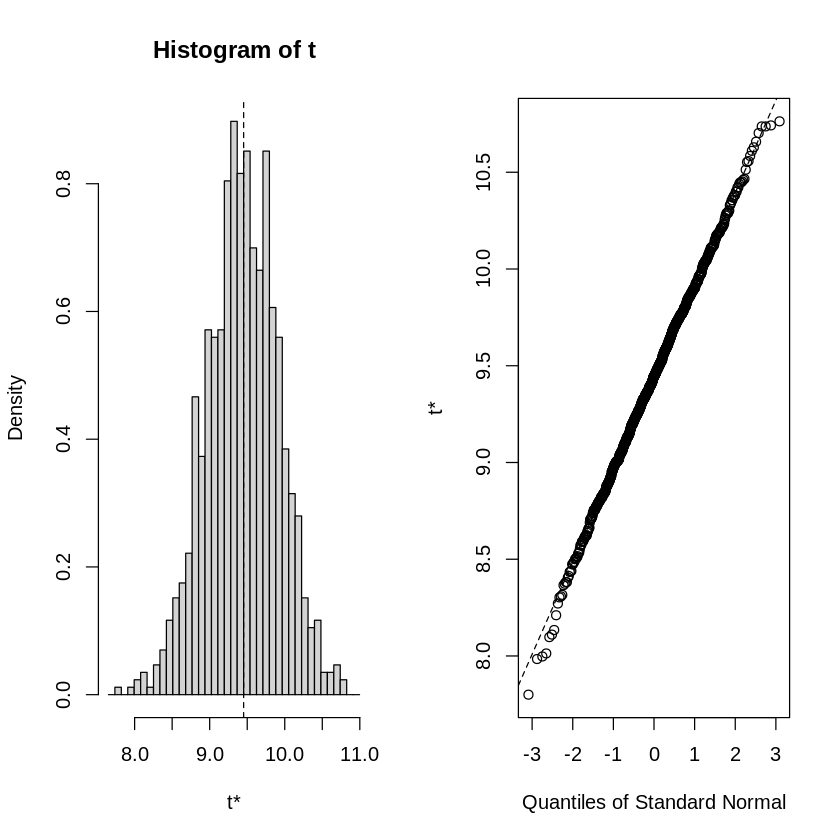

In [199]:
# Определение функции для бутстрэпа
myfn_plasma <- function(data, indices) {
  return(mean(data[indices]))
}

# Бутстрэп для уровня тромбоцитов в плазме крови по возрастным группам
result_bootstrap_plasma <- boot(meta$Plasma.volume, myfn_plasma, R = 1000)
result_bootstrap_plasma

# График
plot(result_bootstrap_plasma)


In [201]:
# Перестановочный тест для уровня тромбоцитов в плазме крови
perm_test_plasma <- oneway_test(Plasma.volume ~ Age_Group, data = meta)

# Результат перестановочного теста
perm_test_plasma



	Asymptotic K-Sample Fisher-Pitman Permutation Test

data:  Plasma.volume by Age_Group (40-50, 51-60, 61-70, 71+)
chi-squared = 7.8788, df = 3, p-value = 0.04858


Результаты перестановочного теста показывают, что существует статистически значимая связь между уровнем тромбоцитов в плазме крови и возрастной группой (p-value = 0.04858).
Таким образом, на основе проведенного анализа можно сделать вывод, что уровень тромбоцитов в плазме крови различается в зависимости от возрастной группы, и эти различия являются статистически значимыми.

**Гипотеза 4: Средний возраст пациентов с диабетом отличается от среднего возраста пациентов без диабета.**


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = meta$Age[meta$Dm == 1], statistic = myfn, R = 1000)


Bootstrap Statistics :
    original  bias    std. error
t1*    61.75 -0.3375    3.520296

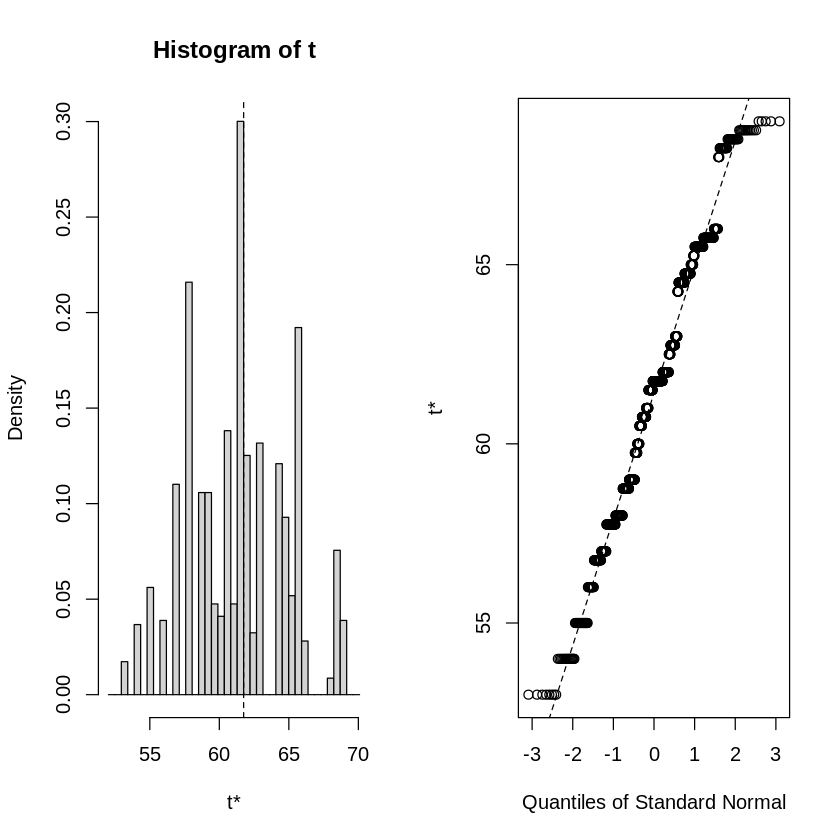

In [ ]:
# Функция для bootstrap
myfn <- function(data, indices) {
  return(mean(data[indices]))
}

# Bootstrap для среднего возраста пациентов с диабетом
result_bootstrap_age <- boot(meta$Age[meta$Dm == 1], myfn, R = 1000)

# Статистика
result_bootstrap_age

# График
plot(result_bootstrap_age)


In [ ]:
# Функция для jackknife
theta <- function(x) {
  return(mean(x))
}

# Jackknife для среднего возраста
results_age_jack <- jackknife(meta$Age[meta$Dm == 1], theta)

# Результат
results_age_jack


$jack.se
[1] 3.986958

$jack.bias
[1] 0

$jack.values
[1] 63.33333 64.66667 59.66667 59.33333

$call
jackknife(x = meta$Age[meta$Dm == 1], theta = theta)


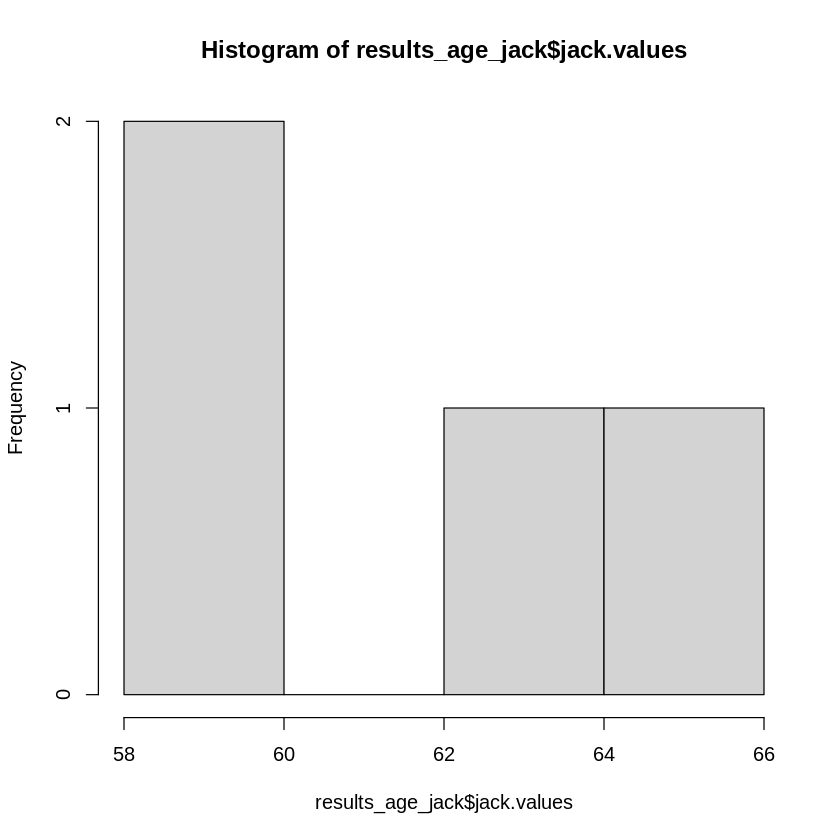

In [ ]:
hist(results_age_jack$jack.values)

In [ ]:
# Преобразование переменной Dm в фактор
meta$Dm <- factor(meta$Dm)

# Перестановочный тест для среднего возраста
perm_test_age <- oneway_test(Age ~ Dm, data = meta)

# Результат
perm_test_age



	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  Age by Dm (0, 1)
Z = 0.93344, p-value = 0.3506
alternative hypothesis: true mu is not equal to 0


На основе проведенных тестов нет достаточных доказательств, чтобы отвергнуть нулевую гипотезу о равенстве средних значений возраста в группах с диабетом и без диабета. Вероятно, различие между этими группами не является статистически значимым.


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = meta$BMI[meta$Sm == 1], statistic = myfn_bmi, R = 1000)


Bootstrap Statistics :
    original     bias    std. error
t1* 24.14793 0.07621711    1.759213


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = meta$BMI[meta$Sm == 0], statistic = myfn_bmi, R = 1000)


Bootstrap Statistics :
    original      bias    std. error
t1* 27.83793 -0.01436317   0.8599603

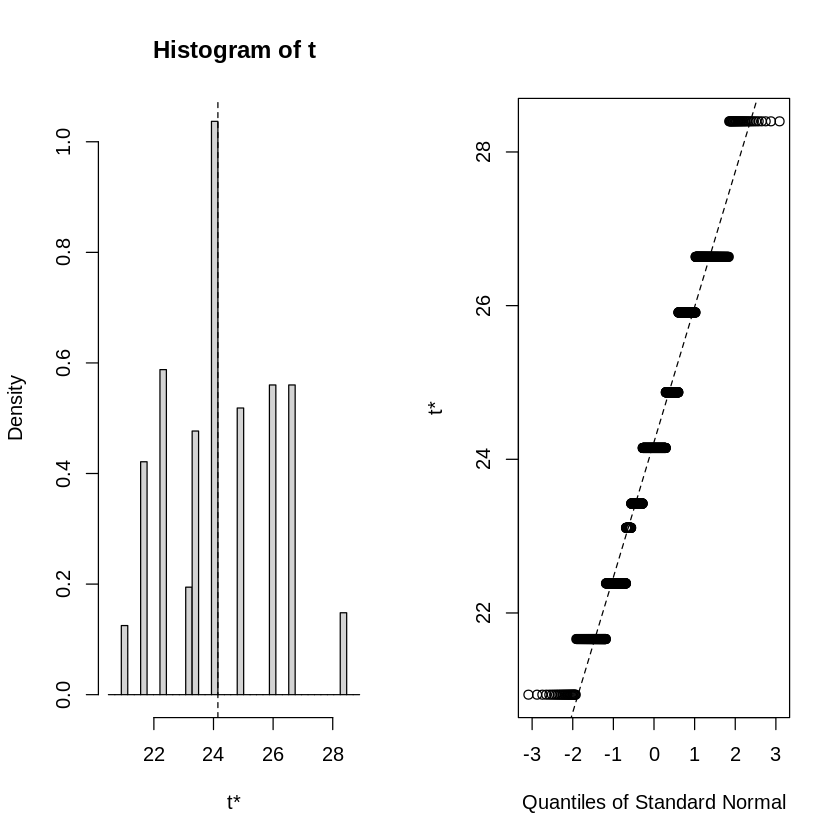

$jack.se
[1] 2.215932

$jack.bias
[1] 0

$jack.values
[1] 22.02254 25.75358 24.66768

$call
jackknife(x = meta$BMI[meta$Sm == 1], theta = theta)


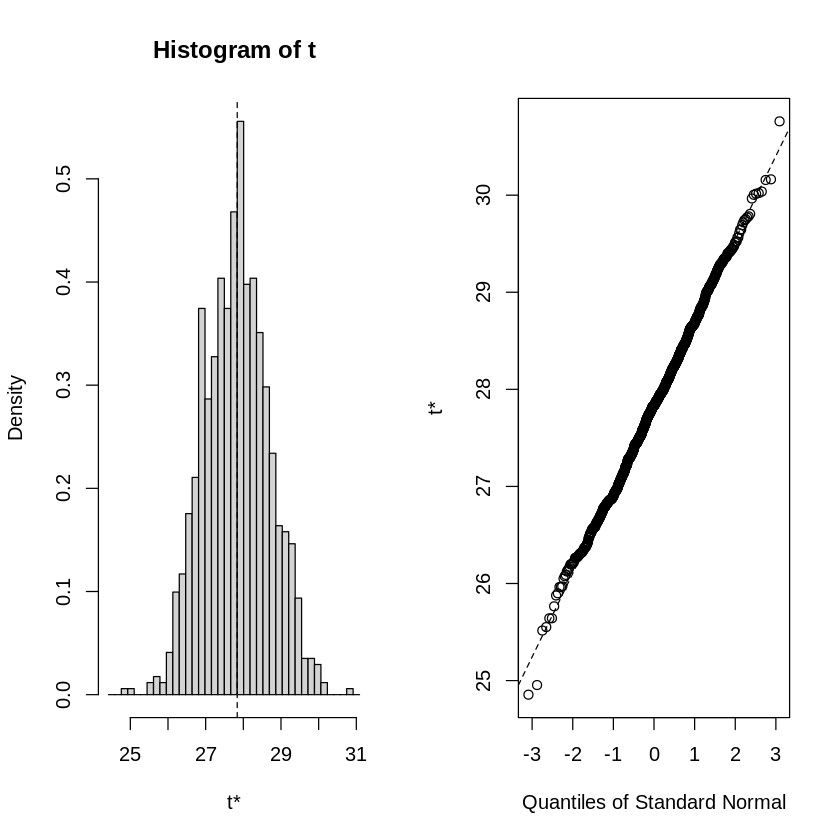

$jack.se
[1] 0.8905025

$jack.bias
[1] 0

$jack.values
 [1] 27.72681 27.63777 27.78186 27.98114 28.01217 27.92140 27.92402 27.97306
 [9] 27.62401 27.77982 28.04186 27.82838 27.84146 27.99229 27.51357 27.62470
[17] 28.00284 27.86806 27.62677 27.84375 28.04631 27.76111 28.01789 28.06018
[25] 27.96735 27.81616 27.81620 28.00343 27.63549 27.81404 27.64683 27.95011
[33] 27.81905 27.57031 27.85725

$call
jackknife(x = meta$BMI[meta$Sm == 0], theta = theta)


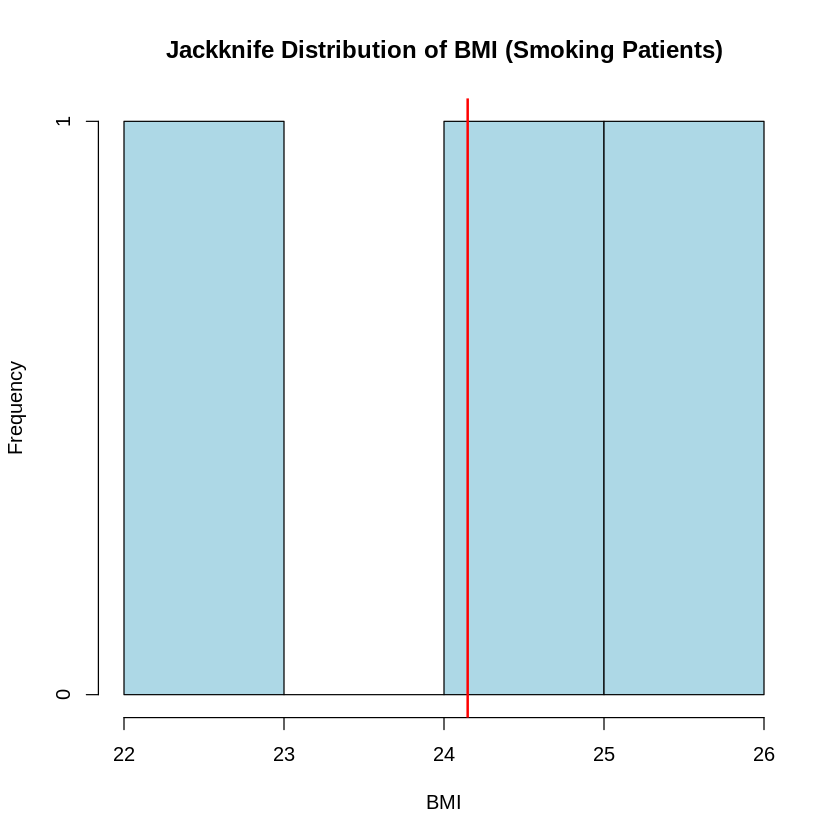


	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  BMI by Sm (0, 1)
Z = 1.1736, p-value = 0.2406
alternative hypothesis: true mu is not equal to 0


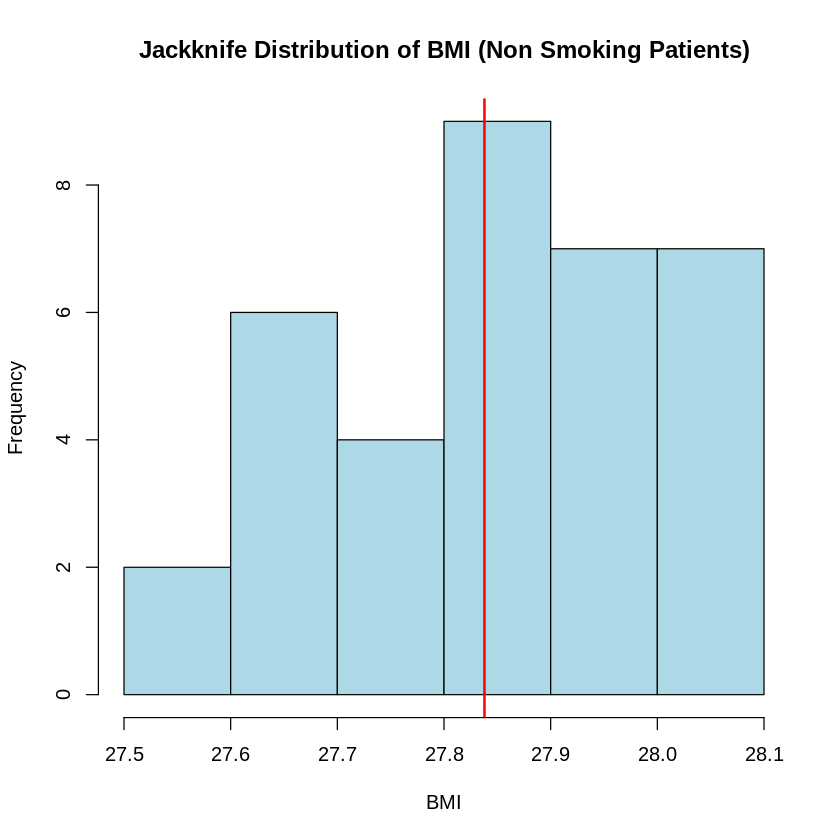

In [ ]:
# Загрузка необходимых библиотек
library(bootstrap)
library(DescTools)

# Функция для Bootstrap
myfn_bmi <- function(data, indices) {
  return(mean(data[indices]))
}

# Bootstrap для среднего BMI у курящих пациентов
result_bootstrap_bmi_smoking <- boot(meta$BMI[meta$Sm == 1], myfn_bmi, R = 1000)
result_bootstrap_bmi_smoking

# Bootstrap для среднего BMI у некурящих пациентов
result_bootstrap_bmi_non_smoking <- boot(meta$BMI[meta$Sm == 0], myfn_bmi, R = 1000)
result_bootstrap_bmi_non_smoking

# Графики Bootstrap
plot(result_bootstrap_bmi_smoking)
plot(result_bootstrap_bmi_non_smoking)

# Функция для Jackknife
theta <- function(x) {
  return(mean(x))
}

# Jackknife для среднего BMI у курящих пациентов
results_bmi_jack_smoking <- jackknife(meta$BMI[meta$Sm == 1])

# Jackknife для среднего BMI у некурящих пациентов
results_bmi_jack_non_smoking <- jackknife(meta$BMI[meta$Sm == 0])

# Результаты Jackknife
results_bmi_jack_smoking

# Получение значений из jackknife
jack_values_smoking <- results_bmi_jack_smoking$jack.values

# Построение графика jackknife
hist(jack_values_smoking, main = "Jackknife Distribution of BMI (Smoking Patients)",
     xlab = "BMI", ylab = "Frequency", col = "lightblue")
abline(v = mean(jack_values_smoking), col = "red", lwd = 2)


results_bmi_jack_non_smoking
# Получение значений из jackknife
jack_values_non_smoking <- results_bmi_jack_non_smoking$jack.values

# Построение графика jackknife
hist(jack_values_non_smoking, main = "Jackknife Distribution of BMI (Non Smoking Patients)",
     xlab = "BMI", ylab = "Frequency", col = "lightblue")
abline(v = mean(jack_values_non_smoking), col = "red", lwd = 2)

# Перестановочный тест для среднего BMI
perm_test_bmi <- oneway_test(BMI ~ Sm, data = meta)

# Результат перестановочного теста
perm_test_bmi


In [ ]:
# Результат перестановочного теста
perm_test_bmi


	Asymptotic Two-Sample Fisher-Pitman Permutation Test

data:  BMI by Sm (0, 1)
Z = 1.1736, p-value = 0.2406
alternative hypothesis: true mu is not equal to 0


Исходя из перестановочного теста, у нас нет достаточных доказательств для отвержения нулевой гипотезы о том, что средние значения BMI у курящих и некурящих пациентов одинаковы. Однако различия в средних значениях между курящими и некурящими пациентами могут быть статистически значимыми, что подтверждается результатами Bootstrap и Jackknife.